In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_07 import *

# Get data

In [3]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [4]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
nh,bs,c

(50, 512, 10)

In [6]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]

# New conv layer

Previously
```python
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)
```

In [11]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): 
        # something that we can add/remove???
        return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [22]:
??get_cnn_model

In [ ]:
??get_cnn_layers

In [23]:
??GeneralRelu

In [25]:
learn,run = get_learn_run(nfs, data, 0.8, ConvLayer, cbs=cbfs)

In [26]:
# GeneralRELU with sub = 0 -> we are using normal RELU here
learn.model

Sequential(
  (0): ConvLayer(
    (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): GeneralRelu()
  )
  (1): ConvLayer(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (2): ConvLayer(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (3): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (4): ConvLayer(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [27]:
run.fit(2, learn)

train: [1.4682936197916667, tensor(0.5035, device='cuda:0')]
valid: [1.45466298828125, tensor(0.6055, device='cuda:0')]
train: [0.4096759440104167, tensor(0.8740, device='cuda:0')]
valid: [0.694948974609375, tensor(0.7825, device='cuda:0')]


# Train with normal RELU

In [33]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [34]:
run.cbs

In [35]:
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch') # make all run.cbs call 'begin_batch'
    # -> apply all 'begin_batch' transformation on batch xb
    # mainly the cuda cb and batchtransform cb
    return run.xb,run.yb

In [36]:
xb,yb = get_batch(data.train_dl, run)

In [38]:
xb.shape,yb.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

In [39]:
def find_modules(m, cond):
    if cond(m): return [m]
#     use sum(list, []) to concatenate the lists the function finds 
# (sum applies the + operate between the elements of the list you pass it, 
# beginning with the initial state in the second argument).
    return sum([find_modules(o,cond) for o in m.children()], [])

In [67]:
sum([[1],[2],[3,4],[5]],[]) # [] is the initial state

[1, 2, 3, 4, 5]

In [68]:
sum([[1],[2],[3,4],[5]],[0]) 

[0, 1, 2, 3, 4, 5]

## Find all conv layer module

In [40]:
mods = find_modules(learn.model, 
                    lambda o: isinstance(o,ConvLayer))

In [43]:
find_modules(learn.model[0], 
                    lambda o: isinstance(o,ConvLayer))

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 )]

In [45]:
find_modules(learn.model[-1], 
                    lambda o: isinstance(o,ConvLayer))

[]

In [44]:
# find all conv layer module
mods = find_modules(learn.model, 
                    lambda o: isinstance(o,ConvLayer))
mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

In [46]:
def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

In [47]:
is_lin_layer(learn.model[0])

False

In [51]:
is_lin_layer(learn.model[0].conv)

True

## Grab mean and std of layer output via hook

In [53]:

def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [54]:
mdl = learn.model.cuda()

In [57]:
??Hook

In [58]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

0.556600034236908 0.7757728099822998
0.69793301820755 0.9241323471069336
0.4469103515148163 0.711616039276123
0.42095839977264404 0.6192539930343628
0.33159029483795166 0.46128761768341064


Bad mean and std because we are using normal RELU (sub=0) and with kaiming init

(Image taken from train-cnn-with-cuda)

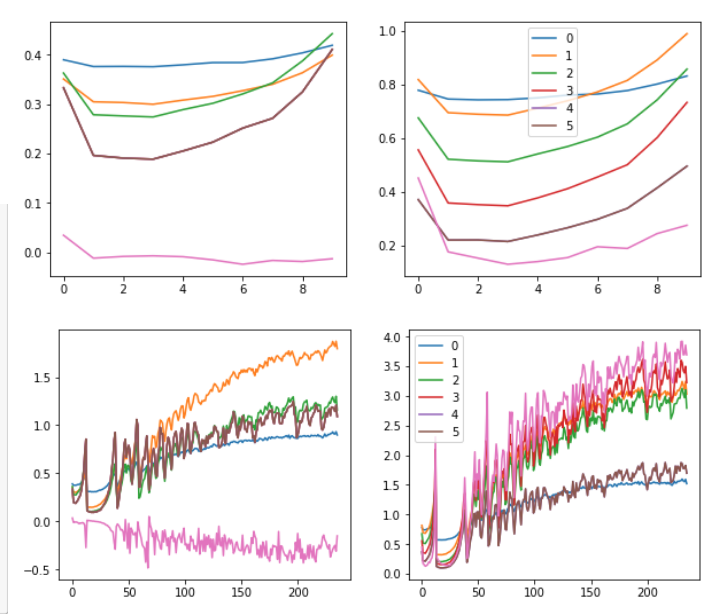

# Train with LSUV

In [75]:
mdl

Sequential(
  (0): ConvLayer(
    (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): GeneralRelu()
  )
  (1): ConvLayer(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (2): ConvLayer(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (3): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (4): ConvLayer(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

Now we're going to look at the paper All You Need is a Good Init, which introduces Layer-wise Sequential Unit-Variance (LSUV). 

We initialize our neural net with the usual technique, then we pass a batch through the model and check the outputs of the linear and convolutional layers. 

**We can then rescale the weights according to the actual variance we observe on the activations, and subtract the mean we observe from the initial bias. That way we will have activations that stay normalized.**

We repeat this process until we are satisfied with the mean/variance we observe.

We first **adjust the bias terms to make the means 0 (by subtracting bias by activation mean)**, then we **adjust the standard deviations to make the stds 1 (by dividing conv2d weight by activation std)** (with a threshold of 1e-3). 

Note that the mean doesn't exactly stay at 0. since we change the standard deviation after by scaling the weight.

The ```mdl(xb) is not None``` clause is just there to pass xb through mdl and compute all the activations so that the hooks get updated.


In [70]:
# note that bias of convlayer is 0 at the beginning
mdl[0].bias

-0.0

In [61]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while mdl(xb) is not None and abs(h.mean)  > 1e-3:
        # when activation mean of layer m is not close to 0 (th 1e-03)
        m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: 
        # when activation std of layer m is not close to 1 (th 1e-03)
        m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

# How to use lsuv

LSUV is run **ONCE** on selected layers (conv2d+generalRELU) at the beginning of training. NOT DURING TRAINING.

You can run a small # of minibatch first (<5) and use LSUV and resuminng training.

In [76]:
for m in mods: # mods is conv layers in mdl
    print(lsuv_module(m, xb))

(0.16087819635868073, 1.0)
(0.061144694685935974, 1.0)
(0.1939261257648468, 1.0)
(0.17334656417369843, 1.0)
(0.29374855756759644, 1.0)


In [79]:
mdl[0].bias
# this is the mean and std of mdl[0] output
# 0.556600034236908 0.7757728099822998

-0.556600034236908

In [81]:
mdl[0].bias

-0.556600034236908

In [80]:
# training is beginning on better grounds.
%time run.fit(2, learn)

train: [0.5811959635416667, tensor(0.8139, device='cuda:0')]
valid: [0.7536908203125, tensor(0.7735, device='cuda:0')]
train: [0.202768994140625, tensor(0.9374, device='cuda:0')]
valid: [0.485277783203125, tensor(0.8531, device='cuda:0')]
CPU times: user 2.04 s, sys: 305 ms, total: 2.34 s
Wall time: 2.36 s


Improve from previous epoch:

train: [0.4096759440104167, tensor(0.8740, device='cuda:0')]

valid: [0.694948974609375, tensor(0.7825, device='cuda:0')]